# Section 2
In this section we will explore the dataframes individually to understand who is involved in accidents and how.


### Python imports

In [1]:
import pandas as pd
import numpy as np
# Provides better color palettes
import seaborn as sns

from pandas import DataFrame,Series

import matplotlib as mpl
import matplotlib.pyplot as plt
# Command to display the plots in the iPython Notebook
%matplotlib inline
import matplotlib.patches as mpatches

mpl.style.use('seaborn-whitegrid')
plt.style.use('seaborn-talk')
# Extract the list of colors from this style for later use
cycl = mpl.rcParams['axes.prop_cycle']
colors = cycl.by_key()['color']

## Who is involved ?
We will start by investigating the Users dataframe to see who is the most, or the least, involved in car accidents. In particular let's look at the age and gender distributions.

In [2]:
users_df = pd.read_hdf('data/2014_France.h5', 'Users')
users_df.head()

,accident id,pedestrian action,user type,pedestrian company,gravity,pedestrian location,vehicle id,location in vehicle,safety gear type,safety gear worn,sex,journey type,age
0,201400000001,0.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,1,5.0,43.0
1,201400000001,0.0,1,0.0,1,0.0,B02,1.0,1.0,1.0,1,5.0,22.0
2,201400000002,0.0,1,0.0,4,0.0,A01,1.0,1.0,1.0,1,5.0,31.0
3,201400000002,0.0,2,0.0,3,0.0,A01,2.0,1.0,1.0,1,0.0,24.0
4,201400000003,0.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,1,5.0,40.0


The best is to have one function drawing the same plots for different input dataframes, i.e. for different conditions.

In [3]:
def men_women_dist(in_df, title=''):
    """Plot the age distribution for men and women, and the ratio."""
    # Extract age for each gender
    women_sr = in_df[in_df['sex']==2]['age'].dropna()
    men_sr = in_df[in_df['sex']==1]['age'].dropna()
    
    # Bin the ages in bins with 2 years of width
    bin_range = range(0,102,2)
    women_bins = pd.cut(women_sr, bin_range,right=False).value_counts().sort_index()
    men_bins = pd.cut(men_sr, bin_range,right=False).value_counts().sort_index()
    
    # Calculate the ratio between men and women
    ratio_bins = men_bins/women_bins
    error_bins = ratio_bins * np.sqrt((men_bins+women_bins)/(men_bins*women_bins))
    
    # Plot the stacked distribution of age for men and women
    plt.subplots(figsize=(14,8))
    plt.subplot(211)
    plt.hist([women_sr,men_sr],bins=50,range=(0,100) , stacked=True, normed = False, histtype='bar',
            rwidth=1.0, color=[colors[1],colors[0]]);
    plt.title(title)
    plt.ylabel('counts')
    leg_men = mpatches.Patch(color=colors[0], label='Men')
    leg_women = mpatches.Patch(color=colors[1], label='Women')
    plt.legend(handles=[leg_men,leg_women],frameon=True)

    # Plot the ratio men/women
    plt.subplot(212)
    plt.errorbar(range(1,100,2),ratio_bins,xerr=1.0,yerr=error_bins, fmt='none')
    plt.xlim([0,100])
    plt.xlabel('age in years')
    plt.ylabel('ratio men/women')

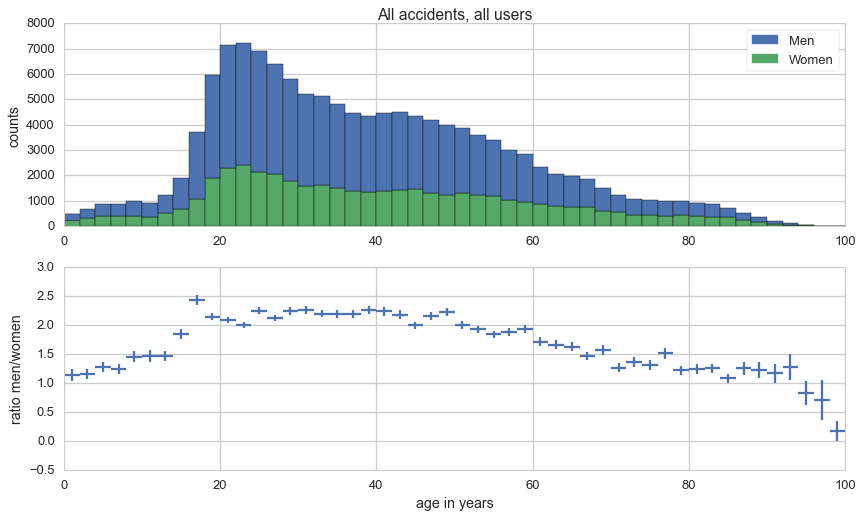

In [4]:
men_women_dist(users_df, 'All accidents, all users')

We can see that men are a lot more involved in accidents than women. Let's try to understand this distribution by looking at the distribution for pedestrians, drivers and passagers separately.

### Pedestrians involved in accidents
Pedestrians are recorded in two categories in the user type column:
- id 3 is for pure pedestrian
- id 4 is for pedestrians using rollerskates or rollerblades

We will combine them here because we are not interested in the different cases

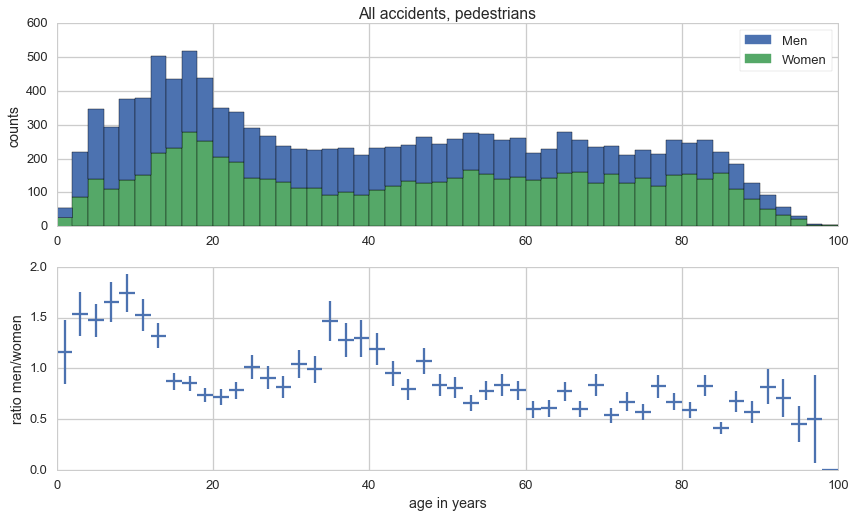

In [5]:
men_women_dist(users_df[(users_df['user type'] == 3) | (users_df['user type'] == 4)] , 'All accidents, pedestrians')

The ratio men/women displays some unexpected variations below 40. This can maybe be explained by different activities and lifestyles at different ages for men and women. The fact that the ratio is less than one above 60 could be due to women living longer than men in average. Numbers on the population by gender of France would be useful here.

### Drivers involved in accidents
The user type is 1 for drivers

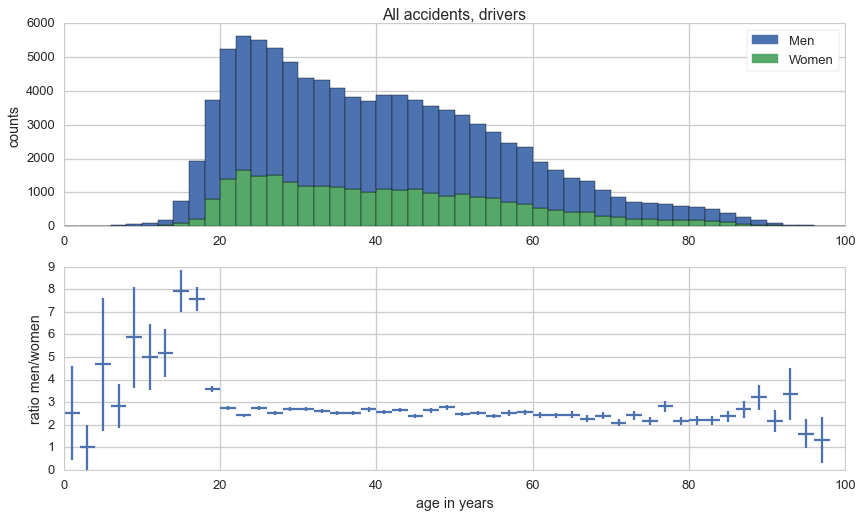

In [6]:
men_women_dist(users_df[users_df['user type'] == 1] , 'All accidents, drivers')

The dataframe contains all vehicle types, including bicycles which is why we have accidents involving drivers under the age of 16. This analysis of the drivers will be easier to interpret if we separate also by vehicle type. However the vehicle type is not stored in the Users dataframe. We need to import the vehicle type from the Vehicles dataframe.

In [7]:
vehicles_df = pd.read_hdf('data/2014_France.h5', 'Vehicles')
users_vt_df = users_df.merge(vehicles_df[['vehicle type','accident id','vehicle id']],
                             on=['accident id','vehicle id'],how='inner')
users_vt_df.head()

,accident id,pedestrian action,user type,pedestrian company,gravity,pedestrian location,vehicle id,location in vehicle,safety gear type,safety gear worn,sex,journey type,age,vehicle type
0,201400000001,0.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,1,5.0,43.0,33
1,201400000001,0.0,1,0.0,1,0.0,B02,1.0,1.0,1.0,1,5.0,22.0,7
2,201400000002,0.0,1,0.0,4,0.0,A01,1.0,1.0,1.0,1,5.0,31.0,7
3,201400000002,0.0,2,0.0,3,0.0,A01,2.0,1.0,1.0,1,0.0,24.0,7
4,201400000003,0.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,1,5.0,40.0,2


Cars are identified with the number 7 in the vehicle type column.

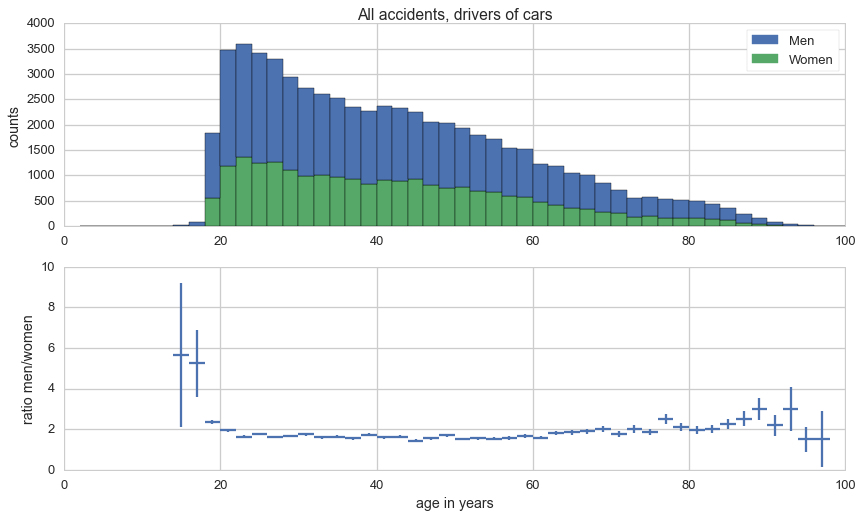

In [8]:
men_women_dist(users_df[(users_df['user type'] == 1) & (users_vt_df['vehicle type'] == 7)] ,
               'All accidents, drivers of cars')

### Passengers involved in accidents

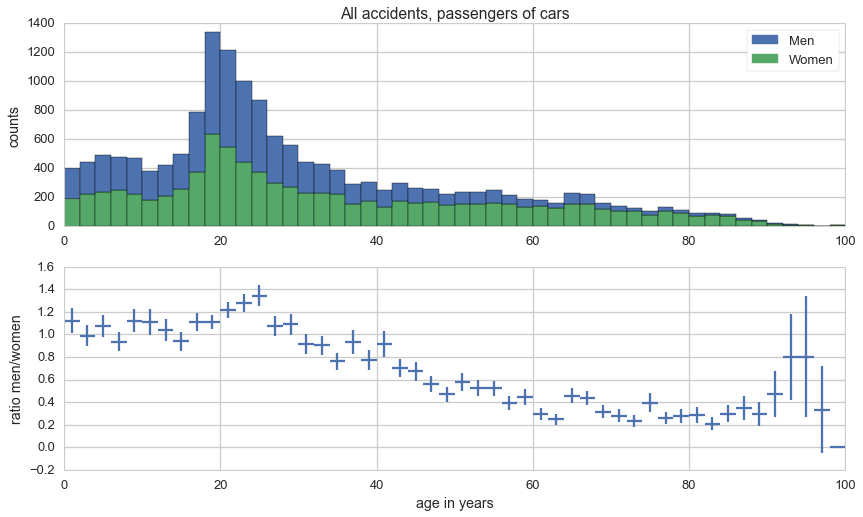

In [11]:
men_women_dist(users_df[(users_df['user type'] == 2) & (users_vt_df['vehicle type'] == 7)] ,
               'All accidents, passengers of cars')

Below 20 the ratio men/women is at 1 which makes sense since the children driven by their parents are distributed equally between the two genders. The slow decrease of the ratio is probably due the tendency of men driving more often than women in most couples.

# What type of vehicles are involved ?